# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model, 
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering, 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering, 
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing 
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [1]:
 #!pip install h5py==2.10.0
 #!pip install numpy
 #!pip install pandas
 #!pip install sklearn
 #!pip install scikit-network
 #!pip install pickle-mixin==1.0.2
 #!pip install matplotlib
 #!pip install plotly

### Prepare Tissue Representations

In [2]:
import h5py
import numpy as np
import pickle
import pandas as pd

In [3]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r') 

In [4]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [5]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [6]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
labels = np.array([x.split('/')[2] for x in filename])
print(filename.shape)
print(labels.shape)

(5000,)
(5000,)


### For inception PCA Feature

#### importing required packages

In [7]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sknetwork.clustering import Louvain
from sklearn.metrics import silhouette_score, v_measure_score

In [8]:
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Getting the index for the features
selected_index = list(np.arange(len(inceptionv3_pca_feature)))

In [10]:
# getting the data and the labels from the selected index
test_data_pca = inceptionv3_pca_feature[selected_index]
test_label_pca = labels[selected_index]

### Kmeans Clustering

1 : 740043008.0
2 : 514760160.0
3 : 413353344.0
4 : 351378304.0
5 : 305539360.0
6 : 278534208.0
7 : 260084800.0
8 : 242286352.0
9 : 229569104.0
10 : 220732592.0
11 : 212181344.0
12 : 204798656.0
13 : 198986240.0
14 : 193958816.0


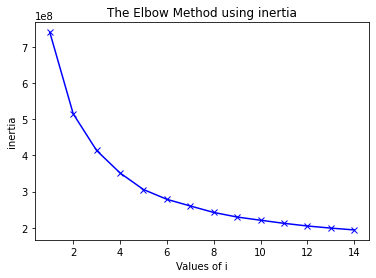

In [11]:
###Performing Elbow Curve for finding out number of clusters

from scipy.spatial.distance import cdist
from sklearn import metrics
import sklearn
import matplotlib.pyplot as plt

inertias = []
mapping = {}

for i in range(1,15):
    kmeans_model_pga_pca = KMeans(n_clusters = i, random_state = 0)
    kmeans_assignment_pga_pca = kmeans_model_pga_pca.fit_predict(test_data_pca)
    inertias.append(kmeans_model_pga_pca.inertia_)
    mapping[i] = kmeans_model_pga_pca.inertia_

for key, val in mapping.items():
    print(f'{key} : {val}')

# plotting the graph for elbow curve
plt.plot(range(1,15), inertias, 'bx-')
plt.xlabel('Values of i')
plt.ylabel('inertia')
plt.title('The Elbow Method using inertia')
plt.show()


#### Silhouette  and V-measure scores 

In [12]:
#Finding out silhouette scores for each cluster from 2 to 15
cluster_range = list(range(2,15))
for i in cluster_range:
    kmeans_model = KMeans(n_clusters = i, random_state = 0) #GaussianMixture(), AgglomerativeClustering(), Louvain
    kmeans_assignment = kmeans_model.fit_predict(test_data_pca)
    kmeans_silhouette = silhouette_score(test_data_pca, kmeans_assignment)
    kmeans_v_measure = v_measure_score(test_label_pca, kmeans_assignment)
    print("For cluster - {0} silhouette_score is {1} ".format(i,kmeans_silhouette,kmeans_v_measure))
    

For cluster - 2 silhouette_score is 0.33123019337654114 
For cluster - 3 silhouette_score is 0.2516070306301117 
For cluster - 4 silhouette_score is 0.25799745321273804 
For cluster - 5 silhouette_score is 0.24224114418029785 
For cluster - 6 silhouette_score is 0.22632041573524475 
For cluster - 7 silhouette_score is 0.22757118940353394 
For cluster - 8 silhouette_score is 0.22510385513305664 
For cluster - 9 silhouette_score is 0.2239283174276352 
For cluster - 10 silhouette_score is 0.2121359407901764 
For cluster - 11 silhouette_score is 0.20980261266231537 
For cluster - 12 silhouette_score is 0.2038850039243698 
For cluster - 13 silhouette_score is 0.20165972411632538 
For cluster - 14 silhouette_score is 0.19482702016830444 


In [13]:
#Perfroming Kmeans with cluster number is 4 from the elbow curve
#considering 4 clusters instead of 5 since silhouette of 4 is higher.

kmeans_model_pca = KMeans(n_clusters = 4, random_state = 0) 
kmeans_assignment_pca = kmeans_model_pca.fit_predict(test_data_pca)

In [14]:
#Finding out V-measure for when number of clusters are 4
kmeans_v_measure_pca = v_measure_score(test_label_pca, kmeans_assignment_pca)
print(kmeans_v_measure_pca)

0.28204291437379386


#### Hierarchical Clustering

In [15]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

### Dendogram

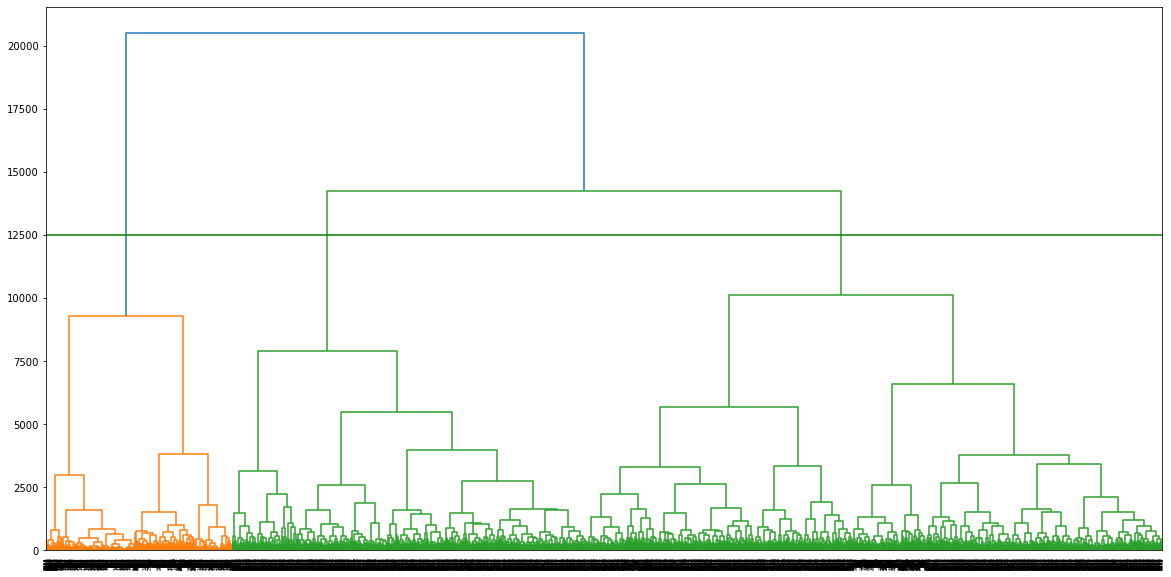

In [16]:
##Finding out optimum number of clusters using dendogram with metric eucldiean distance for formation of trees and cutting the line which gives 3 clusters
plt.figure(figsize = (20,10))
mergings = linkage(test_data_pca, method="ward", metric='euclidean')
dendrogram(mergings)
plt.axhline(y=12500, c='g')
plt.show()


In [17]:
#Performing Agglomerative clustering at 3 clusters
Agg_model_pca = AgglomerativeClustering(n_clusters = 3, linkage = "ward")
Agg_assignment_pca = Agg_model_pca.fit_predict(test_data_pca)

In [18]:
hierarchical_silhouette = silhouette_score(test_data_pca, Agg_assignment_pca)
hierarchical_v_measure = v_measure_score(test_label_pca, Agg_assignment_pca)
print(hierarchical_silhouette)
print(hierarchical_v_measure)

0.2344323
0.24185975572596613


### For inception UMAP feature

In [19]:
# Getting the index for the features
selected_index = list(np.arange(len(inceptionv3_umap_feature)))

In [20]:
# getting the data and the labels from the selected index
test_data_umap = inceptionv3_umap_feature[selected_index]
test_label_umap = labels[selected_index]

### K means Clustering

1 : 137793.671875
2 : 91396.734375
3 : 48783.34375
4 : 26176.14453125
5 : 20272.814453125
6 : 15953.7978515625
7 : 13280.578125
8 : 11002.51171875
9 : 9633.9091796875
10 : 8476.9052734375
11 : 7442.35888671875
12 : 6580.75537109375
13 : 5957.3662109375
14 : 5406.11962890625


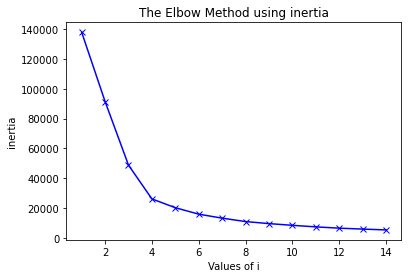

In [21]:
###Performing Elbow Curve for finding out number of clusters

inertias = []
mapping = {}
clusters=[]
i = range(1,15)
for i in range(1,15):

    kmeans_model_pga_pca = KMeans(n_clusters = i, random_state = 0)
    kmeans_assignment_pga_pca = kmeans_model_pga_pca.fit_predict(test_data_umap)
    inertias.append(kmeans_model_pga_pca.inertia_)
    mapping[i] = kmeans_model_pga_pca.inertia_



for key, val in mapping.items():
    print(f'{key} : {val}')

# plotting the elbow curve
plt.plot(range(1,15), inertias, 'bx-')
plt.xlabel('Values of i')
plt.ylabel('inertia')
plt.title('The Elbow Method using inertia')
plt.show()





In [22]:
#Finding out silhouette scores for each cluster from 2 to 15
cluster_range = list(range(2,15))
for i in cluster_range:
    kmeans_model = KMeans(n_clusters = i, random_state = 0) #GaussianMixture(), AgglomerativeClustering(), Louvain
    kmeans_assignment = kmeans_model.fit_predict(test_data_umap)
    kmeans_silhouette = silhouette_score(test_data_umap, kmeans_assignment)
    kmeans_v_measure = v_measure_score(test_label_umap, kmeans_assignment)
    print("For cluster - {0} silhouette_score is {1}".format(i,kmeans_silhouette,kmeans_v_measure))
    

For cluster - 2 silhouette_score is 0.6047378778457642
For cluster - 3 silhouette_score is 0.4574568271636963
For cluster - 4 silhouette_score is 0.5182051658630371
For cluster - 5 silhouette_score is 0.4378841817378998
For cluster - 6 silhouette_score is 0.4617019593715668
For cluster - 7 silhouette_score is 0.46585169434547424
For cluster - 8 silhouette_score is 0.4432564377784729
For cluster - 9 silhouette_score is 0.4591228663921356
For cluster - 10 silhouette_score is 0.4575258195400238
For cluster - 11 silhouette_score is 0.4630686640739441
For cluster - 12 silhouette_score is 0.4490527808666229
For cluster - 13 silhouette_score is 0.4547741115093231
For cluster - 14 silhouette_score is 0.456118643283844


#### Silhouette and V-measure scores

In [23]:
#Perfroming Kmeans with cluster number is 4 from the elbow curve

kmeans_model_umap = KMeans(n_clusters = 4, random_state = 0) 
kmeans_assignment_umap = kmeans_model_umap.fit_predict(test_data_umap)

In [24]:
# Calculating the V measure
kmeans_v_measure_umap = v_measure_score(test_label_umap, kmeans_assignment_umap)
print(kmeans_v_measure_umap)

0.3377578311025106


### Hierarchical(Agglomerative Clustering)

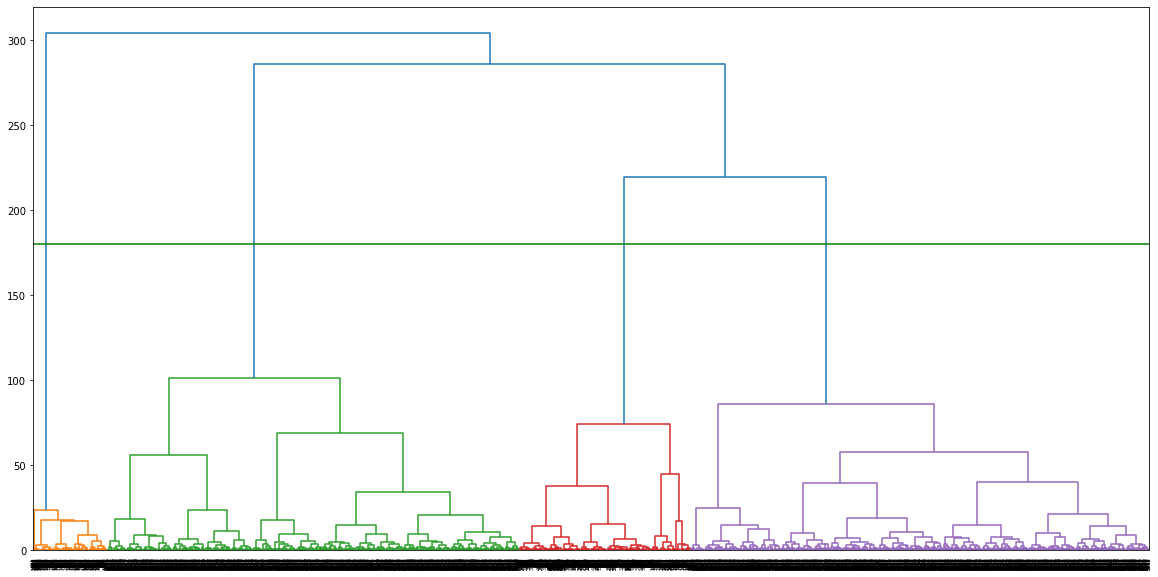

In [25]:
# Dendogram

plt.figure(figsize = (20,10))
mergings = linkage(test_data_umap, method="ward", metric='euclidean')
dendrogram(mergings)
plt.axhline(y = 180 , c = 'g')
plt.show()

In [26]:
# Model fitting for 4 clusters calculated from dendogram
Agg_model_umap = AgglomerativeClustering(n_clusters = 4,linkage='ward')
Agg_assignment_umap = Agg_model_umap.fit_predict(test_data_umap)

In [27]:
# Silhouette and v-measure for 4 clusters
hierarchical_silhouette = silhouette_score(test_data_umap, Agg_assignment_umap)
hierarchical_v_measure = v_measure_score(test_label_umap, Agg_assignment_umap)
print(hierarchical_silhouette)
print(hierarchical_v_measure)

0.5141981
0.33223617076230727


### PGE CONTENT

### For PGE PCA feature sets

Getting the data and labels from the feature

In [28]:
selected_index = list(np.arange(len(pge_pca_feature)))
pga_pca_data = pge_pca_feature[selected_index]
pga_pca_label = labels[selected_index]

print(pga_pca_data.shape)
print(pga_pca_label.shape)

(5000, 100)
(5000,)


#### K-Means Clustering

1 : 101035.640625
2 : 71638.7890625
3 : 62970.7890625
4 : 58730.18359375
5 : 55229.22265625
6 : 52347.47265625
7 : 50121.69140625
8 : 48451.3046875
9 : 46984.8828125
10 : 45579.94921875
11 : 44345.58984375
12 : 43412.4921875
13 : 42297.71484375
14 : 41414.62890625
15 : 40644.30859375


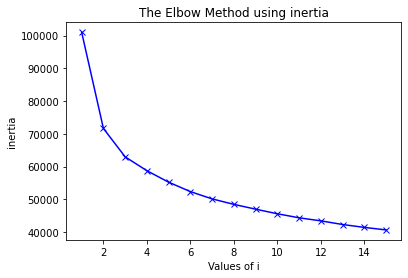

In [29]:
# K-means clustering using elbow curve
inertias = []
inertiamapping = {}

i = range(1,16)
for i in range(1,16):
    
    kmeans_model_pga_pca = KMeans(n_clusters = i, random_state = 0)
    kmeans_assignment_pga_pca = kmeans_model_pga_pca.fit_predict(pga_pca_data)
    
    inertias.append(kmeans_model_pga_pca.inertia_)
    
    inertiamapping[i] = kmeans_model_pga_pca.inertia_
    

for key, val in inertiamapping.items():
    print(f'{key} : {val}')

# plotting the graph for elbow curve
plt.plot(range(1,16), inertias, 'bx-')
plt.xlabel('Values of i')
plt.ylabel('inertia')
plt.title('The Elbow Method using inertia')
plt.show()


#### Silhoutte Scores and V-Measure

In [30]:
from sklearn.metrics import silhouette_score, v_measure_score
for i in range(2,11):
    kmeans_model_pga_pca = KMeans(n_clusters = i, random_state = 0)
    kmeans_assignment_pga_pca1 = kmeans_model_pga_pca.fit_predict(pga_pca_data)
    kmeans_silhouette_pga_pca=silhouette_score(pga_pca_data, kmeans_assignment_pga_pca1)
    kmeans_v_measure_pga_pca=v_measure_score(pga_pca_label, kmeans_assignment_pga_pca1)
    print('For Cluster - ',i,' silhouette score is: ',kmeans_silhouette_pga_pca)

For Cluster -  2  silhouette score is:  0.3077827
For Cluster -  3  silhouette score is:  0.16621602
For Cluster -  4  silhouette score is:  0.13885812
For Cluster -  5  silhouette score is:  0.12939876
For Cluster -  6  silhouette score is:  0.1371577
For Cluster -  7  silhouette score is:  0.13784556
For Cluster -  8  silhouette score is:  0.13913155
For Cluster -  9  silhouette score is:  0.14220078
For Cluster -  10  silhouette score is:  0.14571655


In [31]:
# Considering 3 clusters from elbvow and silhouette scores.

kmeans_model_pga_pca = KMeans(n_clusters = 3, random_state = 0)
kmeans_assignment_pga_pca_1 = kmeans_model_pga_pca.fit_predict(pga_pca_data)
kmeans_silhouette_pga_pca=silhouette_score(pga_pca_data, kmeans_assignment_pga_pca_1)
kmeans_v_measure_pga_pca=v_measure_score(pga_pca_label, kmeans_assignment_pga_pca_1)
print('silhouette',kmeans_silhouette_pga_pca)
print('v-measure',kmeans_v_measure_pga_pca)

silhouette 0.16621602
v-measure 0.29294306766637346


#### Hierarchical (Agglomerative) Clustering 

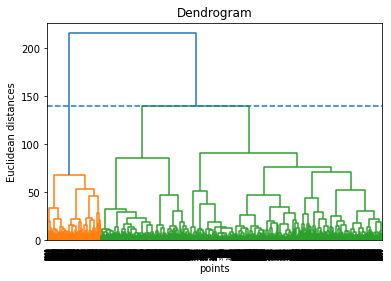

In [32]:
# Dendogram for pge pca data

import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(pga_pca_data, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('points')
plt.ylabel('Euclidean distances')
plt.axhline(linestyle='--', y=140)
plt.show() 

In [33]:
for i in range(2,16):
    hierarchical_model_pga_pca = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage ='ward')
    hierarchical_assignment_pga_pca = hierarchical_model_pga_pca.fit_predict(pga_pca_data)

In [34]:
#Calculating the silhouette and v-measure 

hierarchical_model_pga_pca = AgglomerativeClustering(n_clusters =3 , affinity = 'euclidean', linkage ='ward')
hierarchical_assignment_pga_pca_1 = hierarchical_model_pga_pca.fit_predict(pga_pca_data)

hierarchical_silhouette_pga_pca = silhouette_score(pga_pca_data, hierarchical_assignment_pga_pca_1)
hierarchical_v_measure_pga_pca = v_measure_score(pga_pca_label, hierarchical_assignment_pga_pca_1)

pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Hierarchaical': [hierarchical_silhouette_pga_pca, hierarchical_v_measure_pga_pca]}).set_index('Metrics')

,Hierarchaical
Metrics,
silhouette,0.137688
V-measure,0.220583


### For PGE UMAP feature sets

#### K-Means Clustering

In [35]:
selected_index = list(np.arange(len(pge_umap_feature)))
pga_umap_data = pge_umap_feature[selected_index]
pga_umap_label = labels[selected_index]

1 : 164243.265625
2 : 112422.1953125
3 : 68757.0703125
4 : 48758.3671875
5 : 33622.8203125
6 : 22904.005859375
7 : 16301.9580078125
8 : 12302.1259765625
9 : 10127.42578125
10 : 8341.8681640625
11 : 7075.7587890625
12 : 6019.6982421875
13 : 5489.396484375
14 : 4881.21728515625


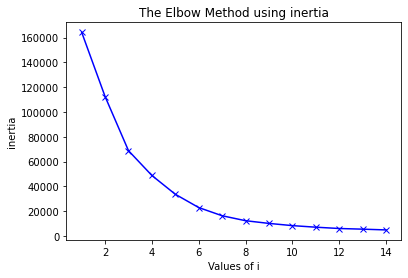

In [36]:
# Calculating the Kmeans using elbow method

inertias = []
inertiamapping2 = {}
i = range(1,15)
for i in range(1,15):
    
    kmeans_model_pga_umap = KMeans(n_clusters = i, random_state = 0)
    kmeans_assignment_pga_umap = kmeans_model_pga_umap.fit_predict(pga_umap_data)
    inertias.append(kmeans_model_pga_umap.inertia_)
    inertiamapping2[i] = kmeans_model_pga_umap.inertia_
    

for key, val in inertiamapping2.items():
    print(f'{key} : {val}')

#Plotting the elbow curve
plt.plot(range(1,15), inertias, 'bx-')
plt.xlabel('Values of i')
plt.ylabel('inertia')
plt.title('The Elbow Method using inertia')
plt.show()

    

#### Silhouette and V-measure

In [37]:
for i in range(2,11):
    kmeans_model_pga_umap = KMeans(n_clusters = i, random_state = 0)
    kmeans_assignment_pga_umap = kmeans_model_pga_umap.fit_predict(pga_umap_data)
    kmeans_silhouette_pga_umap=silhouette_score(pga_umap_data, kmeans_assignment_pga_umap)
    kmeans_v_measure_pga_umap=v_measure_score(pga_umap_label, kmeans_assignment_pga_umap)
    print('For Cluster - ',i,' silhouette score is: ',kmeans_silhouette_pga_umap)

For Cluster -  2  silhouette score is:  0.41184482
For Cluster -  3  silhouette score is:  0.48857954
For Cluster -  4  silhouette score is:  0.5153348
For Cluster -  5  silhouette score is:  0.55324054
For Cluster -  6  silhouette score is:  0.5880003
For Cluster -  7  silhouette score is:  0.6156872
For Cluster -  8  silhouette score is:  0.54528713
For Cluster -  9  silhouette score is:  0.53081495
For Cluster -  10  silhouette score is:  0.5296201


In [38]:
#Considering 5 clusters based on elbow and silhouette

kmeans_model_pga_umap = KMeans(n_clusters = 5, random_state = 0)
kmeans_assignment_pga_umap_1 = kmeans_model_pga_umap.fit_predict(pga_umap_data)
kmeans_silhouette_pga_umap=silhouette_score(pga_umap_data, kmeans_assignment_pga_umap_1)
kmeans_v_measure_pga_umap=v_measure_score(pga_umap_label, kmeans_assignment_pga_umap_1)
print('silhouette',kmeans_silhouette_pga_umap)
print('v-measure',kmeans_v_measure_pga_umap)

silhouette 0.55324054
v-measure 0.4792589387065739


#### Hierachical (Agglomerative) Clustering

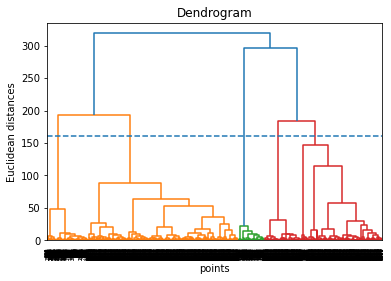

In [39]:
# Dendogram for Umap data

dendrogram = sch.dendrogram(sch.linkage(pga_umap_data, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('points')
plt.ylabel('Euclidean distances')
plt.axhline(linestyle='--', y=160)
plt.show()

In [40]:
for i in range(2,16):
    hierarchical_model_pga_umap = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage ='ward')
    hierarchical_assignment_pga_umap = hierarchical_model_pga_umap.fit_predict(pga_umap_data)

In [41]:
# Calculating silhouette and v-measure for 5 clusters based on dendogram

hierarchical_model_pga_umap = AgglomerativeClustering(n_clusters =5 , affinity = 'euclidean', linkage ='ward')
hierarchical_assignment_pga_umap_1 = hierarchical_model_pga_umap.fit_predict(pga_umap_data)

hierarchical_silhouette_pga_umap = silhouette_score(pga_umap_data, hierarchical_assignment_pga_umap_1)
hierarchical_v_measure_pga_umap = v_measure_score(pga_umap_label, hierarchical_assignment_pga_umap_1)

pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Hierarchaical': [hierarchical_silhouette_pga_umap, hierarchical_v_measure_pga_umap]}).set_index('Metrics')

,Hierarchaical
Metrics,
silhouette,0.553102
V-measure,0.480297


### Evaluation and Visualization

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split

#### PathologyGAN

In [43]:
print('Number of clusters for PCA reduction in PathologyGAN from KMeans: %d and from Hierarchical: %d'%(np.unique(kmeans_assignment_pga_pca_1).shape[0],np.unique(hierarchical_assignment_pga_pca_1).shape[0]))

Number of clusters for PCA reduction in PathologyGAN from KMeans: 3 and from Hierarchical: 3


In [44]:
print('Number of clusters for UMAP reduction in PathologyGAN from KMeans: %d and from Hierarchical: %d'%(np.unique(kmeans_assignment_pga_umap_1).shape[0],np.unique(hierarchical_assignment_pga_umap_1).shape[0]))

Number of clusters for UMAP reduction in PathologyGAN from KMeans: 5 and from Hierarchical: 5


#### PGE PCA Evaluations:

In [45]:
kmeans_pca_counts = np.unique(kmeans_assignment_pga_pca_1, return_counts = True)
hierarchical_pca_counts = np.unique(hierarchical_assignment_pga_pca_1, return_counts = True)

In [46]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_pca_counts[0], 'Number of members':kmeans_pca_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


,Number of members
Cluster Index,
0,2197
1,1704
2,1099


In [47]:
print('Hierarchical assignment counts')
pd.DataFrame({'Cluster Index': hierarchical_pca_counts[0], 'Number of members':hierarchical_pca_counts[1]}).set_index('Cluster Index')

Hierarchical assignment counts


,Number of members
Cluster Index,
0,2865
1,799
2,1336


#### PGE UMAP Evaluations

In [48]:
kmeans_umap_counts = np.unique(kmeans_assignment_pga_umap_1, return_counts = True)
hierarchical_umap_counts = np.unique(hierarchical_assignment_pga_umap_1, return_counts = True)

In [49]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_umap_counts[0], 'Number of members':kmeans_umap_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


,Number of members
Cluster Index,
0,2218
1,557
2,386
3,618
4,1221


In [50]:
print('Hierarchical assignment counts')
pd.DataFrame({'Cluster Index': hierarchical_umap_counts[0], 'Number of members':hierarchical_umap_counts[1]}).set_index('Cluster Index')

Hierarchical assignment counts


,Number of members
Cluster Index,
0,1201
1,2249
2,386
3,613
4,551


* Assess goodness of fit by silhouette score and cluster homogeneities by V-measure

In [51]:
kmeans_pca_silhouette = silhouette_score(pga_pca_data, kmeans_assignment_pga_pca_1)
heirarchical_pca_silhouette = silhouette_score(pga_pca_data, hierarchical_assignment_pga_pca_1)
kmeans_pca_v_measure = v_measure_score(pga_pca_label, kmeans_assignment_pga_pca_1)
heirarchical_pca_v_measure = v_measure_score(pga_pca_label, hierarchical_assignment_pga_pca_1)

kmeans_umap_silhouette = silhouette_score(pga_umap_data, kmeans_assignment_pga_umap_1)
heirarchical_umap_silhouette = silhouette_score(pga_umap_data, hierarchical_assignment_pga_umap_1)
kmeans_umap_v_measure = v_measure_score(pga_umap_label, kmeans_assignment_pga_umap_1)
heirarchical_umap_v_measure = v_measure_score(pga_umap_label, hierarchical_assignment_pga_umap_1)

print('Evaluations for PathologyGAN')
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans PCA': [kmeans_pca_silhouette, kmeans_pca_v_measure], 'Heirarchical PCA':[heirarchical_pca_silhouette, heirarchical_pca_v_measure], 'Kmeans UMAP':[kmeans_umap_silhouette, kmeans_umap_v_measure], 'Heirarchical UMAP':[heirarchical_umap_silhouette, heirarchical_umap_v_measure], }).set_index('Metrics')

Evaluations for PathologyGAN


,Kmeans PCA,Heirarchical PCA,Kmeans UMAP,Heirarchical UMAP
Metrics,,,,
silhouette,0.166216,0.137688,0.553241,0.553102
V-measure,0.292943,0.220583,0.479259,0.480297


### InceptionV3 

In [52]:
print('Number of clusters for PCA reduction in InceptionV3 from KMeans: %d and from Hierarchical: %d'%(np.unique(kmeans_assignment_pca).shape[0],np.unique(Agg_assignment_pca).shape[0]))

Number of clusters for PCA reduction in InceptionV3 from KMeans: 4 and from Hierarchical: 3


In [53]:
print('Number of clusters for UMAP reduction in InceptionV3 from KMeans: %d and from Hierarchical: %d'%(np.unique(kmeans_assignment_umap).shape[0],np.unique(Agg_assignment_umap).shape[0]))

Number of clusters for UMAP reduction in InceptionV3 from KMeans: 4 and from Hierarchical: 4


#### InceptionV3 PCA Evaluations

In [54]:
kmeans_pca_counts = np.unique(kmeans_assignment_pca, return_counts = True)
hierarchical_pca_counts = np.unique(Agg_assignment_pca, return_counts = True)

In [55]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_pca_counts[0], 'Number of members':kmeans_pca_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


,Number of members
Cluster Index,
0,2195
1,1470
2,875
3,460


In [56]:
print('Hierarchical assignment counts')
pd.DataFrame({'Cluster Index': hierarchical_pca_counts[0], 'Number of members':hierarchical_pca_counts[1]}).set_index('Cluster Index')

Hierarchical assignment counts


,Number of members
Cluster Index,
0,2574
1,835
2,1591


### InceptionV3 UMAP Evaluations

In [57]:
kmeans_umap_counts = np.unique(kmeans_assignment_umap, return_counts = True)
hierarchical_umap_counts = np.unique(Agg_assignment_umap, return_counts = True)

In [58]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_umap_counts[0], 'Number of members':kmeans_umap_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


,Number of members
Cluster Index,
0,1846
1,2079
2,330
3,745


In [59]:
print('Hierarchical assignment counts')
pd.DataFrame({'Cluster Index': hierarchical_umap_counts[0], 'Number of members':hierarchical_umap_counts[1]}).set_index('Cluster Index')

Hierarchical assignment counts


,Number of members
Cluster Index,
0,1849
1,766
2,2055
3,330


In [60]:
kmeans_silhouette_pca = silhouette_score(test_data_pca, kmeans_assignment_pca)
agg_silhoette_pca = silhouette_score(test_data_pca, Agg_assignment_pca)
kmeans_v_measure_pca = v_measure_score(test_label_pca, kmeans_assignment_pca)
agg_v_measure_pca = v_measure_score(test_label_pca, Agg_assignment_pca)


kmeans_silhouette_umap = silhouette_score(test_data_umap, kmeans_assignment_umap)
agg_silhoette_umap = silhouette_score(test_data_umap, Agg_assignment_umap)
kmeans_v_measure_umap = v_measure_score(test_label_umap, kmeans_assignment_umap)
agg_v_measure_umap = v_measure_score(test_label_umap, Agg_assignment_umap)

print("Inception Data")
print("-------------------------------------------------")
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans PCA ': [kmeans_silhouette_pca, kmeans_v_measure_pca], 'Hierarchical PCA':[agg_silhoette_pca, agg_v_measure_pca], 'Kmeans UMAP ': [kmeans_silhouette_umap, kmeans_v_measure_umap],'Hierarchical UMAP':[agg_silhoette_umap, agg_v_measure_umap]}).set_index('Metrics')

Inception Data
-------------------------------------------------


,Kmeans PCA,Hierarchical PCA,Kmeans UMAP,Hierarchical UMAP
Metrics,,,,
silhouette,0.257997,0.234432,0.518205,0.514198
V-measure,0.282043,0.241860,0.337758,0.332236


* Visualise tissue type percentage in two different clustering configurations

In [61]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

#### Visualization for PGE PCA Data

<ipython-input-62-e822aeab265f>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


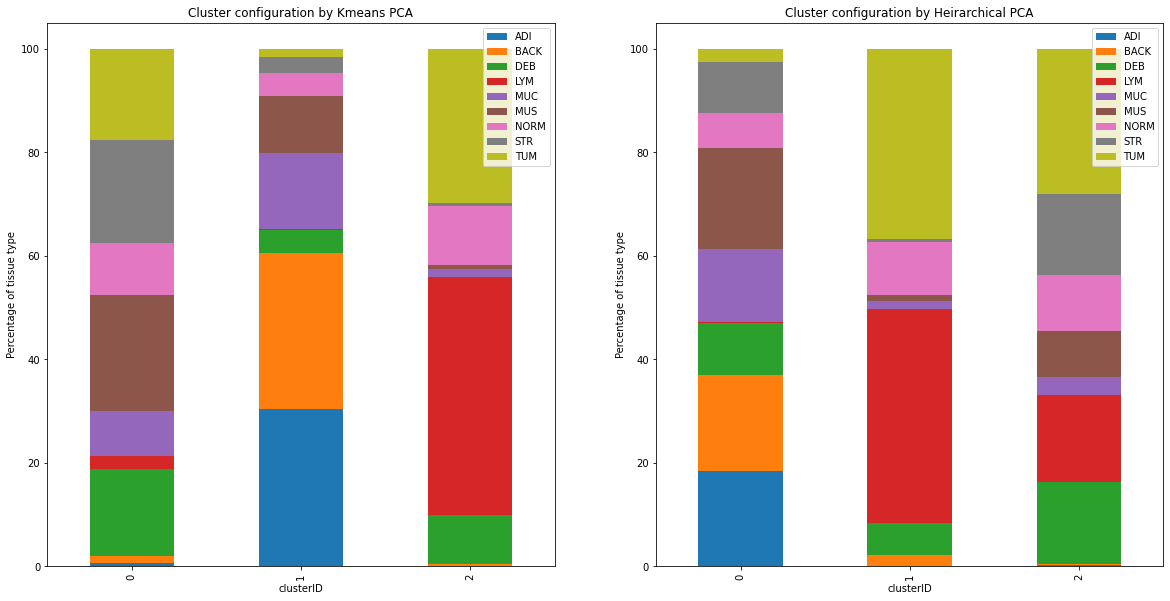

In [62]:
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_pga_pca_1, 'type': pga_pca_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,10))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans PCA')

resulted_cluster_df = pd.DataFrame({'clusterID': hierarchical_assignment_pga_pca_1, 'type': pga_pca_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Heirarchical PCA')
f.show()

#### Visualization for PGE UMAP Data

<ipython-input-63-044ffc32e551>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


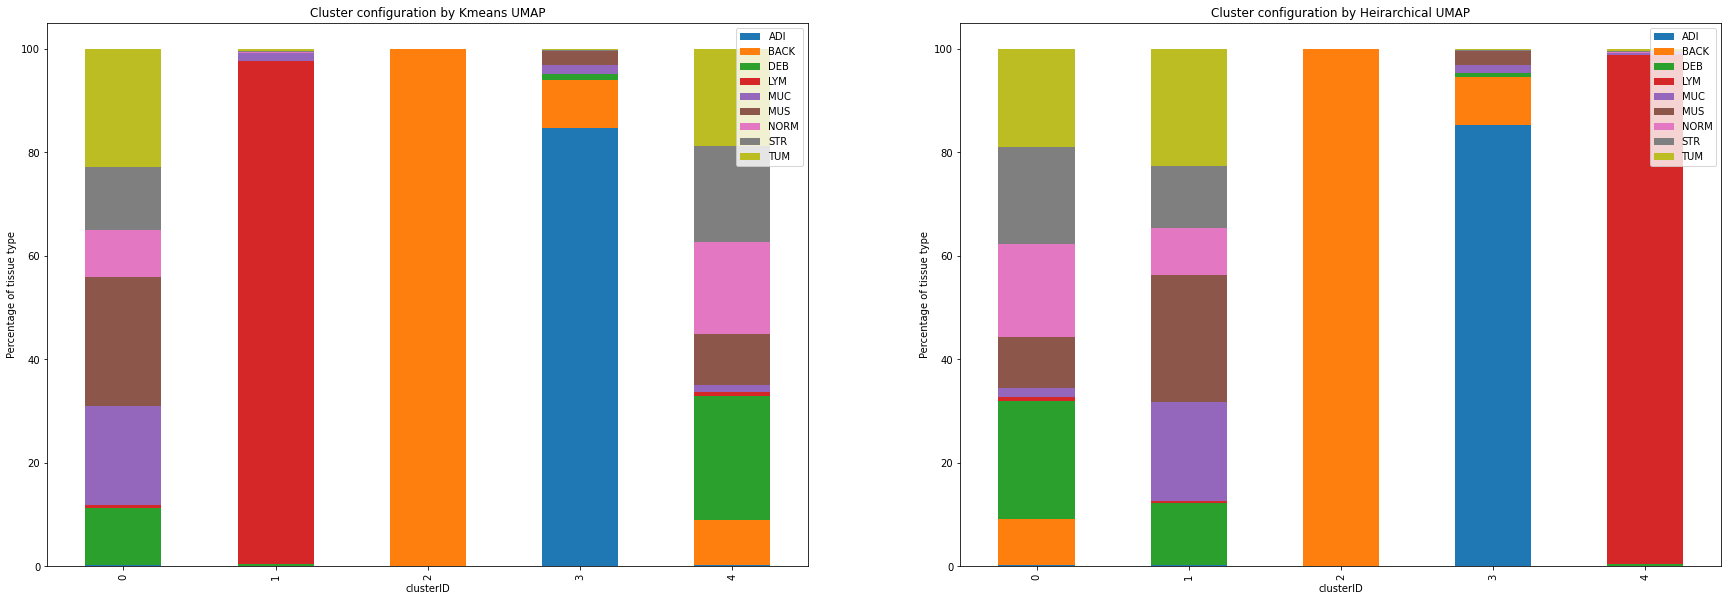

In [63]:
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_pga_umap_1, 'type': pga_umap_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(30,10))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans UMAP')

resulted_cluster_df = pd.DataFrame({'clusterID': hierarchical_assignment_pga_umap_1, 'type': pga_umap_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Heirarchical UMAP')
f.show()

#### Visualization of InceptionV3 PCA Data

<ipython-input-64-3eac2b8340ff>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


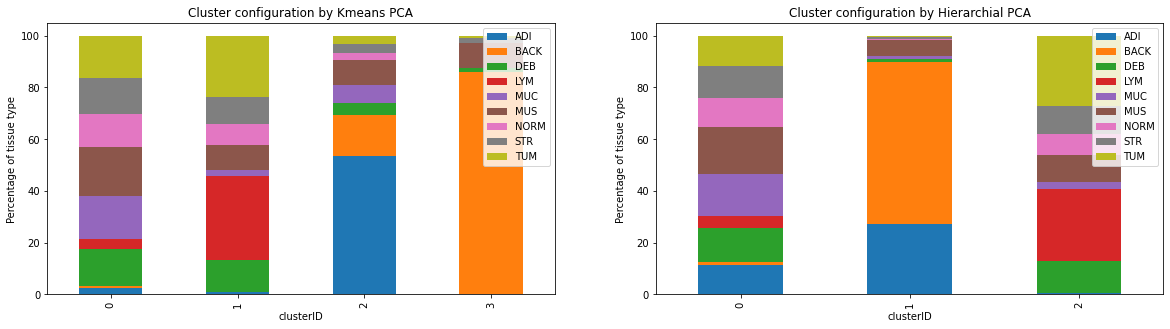

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_pca, 'type': test_label_pca})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans PCA')

resulted_cluster_df = pd.DataFrame({'clusterID': Agg_assignment_pca, 'type': test_label_pca})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchial PCA')
f.show()

#### Visualization of InceptionV3 UMAP Data

<ipython-input-65-e584f2a8fc67>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


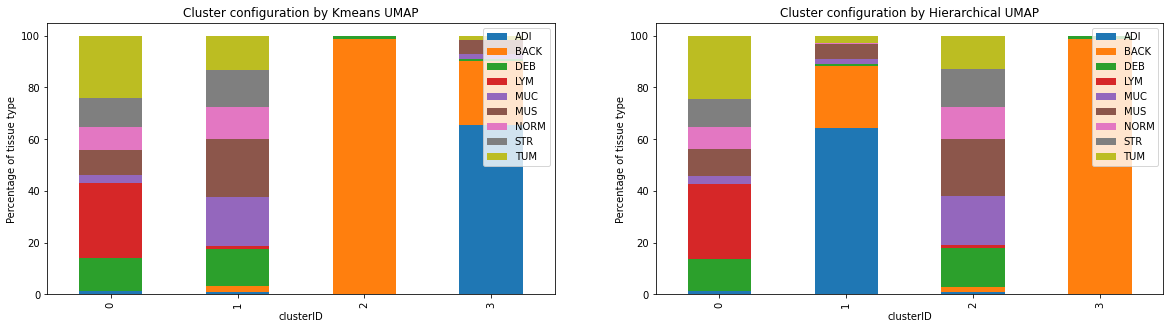

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment_umap, 'type': test_label_umap})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans UMAP')

resulted_cluster_df = pd.DataFrame({'clusterID': Agg_assignment_umap, 'type': test_label_umap})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Hierarchical UMAP')
f.show()

#### Considering the results we got for PathologyGAN and InceptionV3 we can see that K-Means has better silhouette and V-measure scores when compared to Hierarchical Clustering.